# Stock forecasting with LSTM Neural Networks

Greetings all. I woke up today and decided to stop being a lazy useless waste of space and to try and do a project.
As of writing this, I have no background in data science or finance. I only come equipped with a will to learn, so this post may be filled with errors. Do please let me know of any errors or improvements I could make.

# Introduction

Let's start off with the star of the show, the Long-Short Term Memory (LSTM) network. LSTM is a class of recurrent neural network that is able to draw connections between nodes along a temporal sequence, allowing information flowing throughout the network to persist. This allows it to handle time series data, such as our stock prices.

How do LSTMs work? Here's an amazing blog I used to understand more: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

# 1. Data Exploration

First of all, let's load our data. For this, I'll will be using yfinance, a tool that uses Yahoo Finance's APIs to extract market data.
For today, I think I'm going to use Google, stock ticker GOOG.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials 

In [2]:
df_goog = yf.download("GOOG",
                start = "2019-01-01",
                end = "2022-01-01",
                )

# Let's look at our data.
df_goog.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,1050.959961,1052.699951,1023.590027,1035.609985,1035.609985,1493300
2019-01-02,1016.570007,1052.319946,1015.710022,1045.849976,1045.849976,1532600
2019-01-03,1041.000000,1056.979980,1014.070007,1016.059998,1016.059998,1841100
2019-01-04,1032.589966,1070.839966,1027.417969,1070.709961,1070.709961,2093900
2019-01-07,1071.500000,1074.000000,1054.760010,1068.390015,1068.390015,1981900


We have the following variables in our dataset:

Open: The stock price at market open.

High: The highest stock price that trading day

Adjusted Close: The adjusted value of the stock considering coporate actions such as dividends, stock splits, new stock offerings etc.

Volume: The number of shares traded in a particular stock, index, or other investment over a specific period of time.

In [3]:
# Check for null values
df = df_goog
df[df.isnull().any(axis = 1)]


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [4]:
# Check data types
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

It does not seem like we have any null values or strange data types so it would be safe to move on.
But it is worth mentioning that there are lapse in the dates within the dataset, this is because the markets are not open for trade every day.

Now let's begin taking a look at our data, we will first import matplotlib and take a look at the relationship between Open, High and Close.

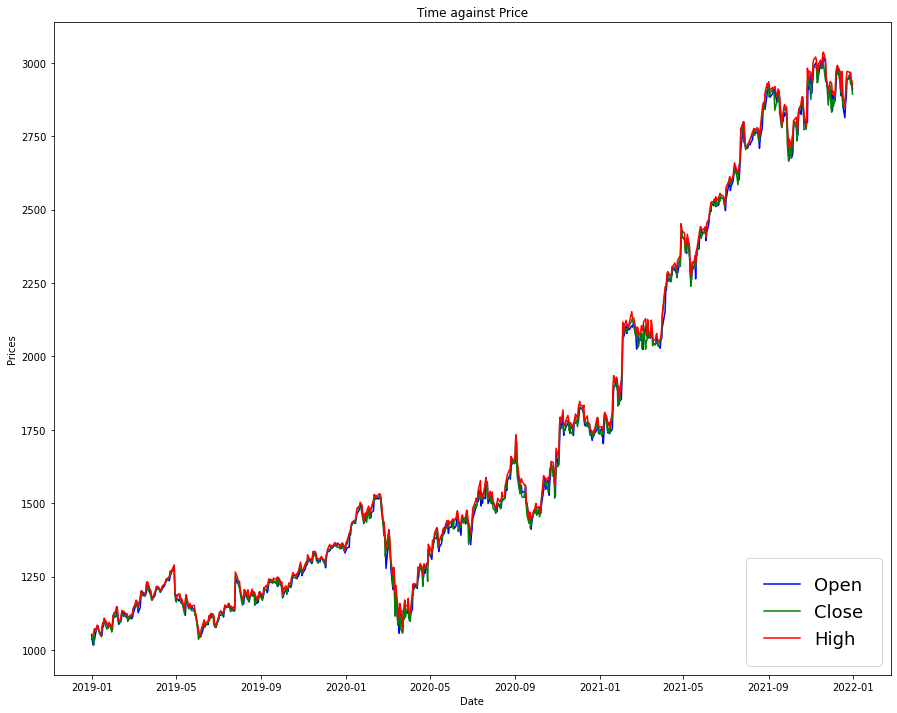

In [5]:
import matplotlib as plot
from matplotlib import pyplot as plt

# lets first see the relationship between the prices

plt.figure(figsize = (15,12))
plt.plot(df['Open'], color = 'blue', label = 'Open')
plt.plot(df['Close'], color = 'green', label = 'Close')
plt.plot(df['High'], color = 'red', label = 'High')
plt.title('Time against Price')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend(loc = 'lower right', borderpad = 1, fontsize = 18)
plt.show()

As per our expectations, the three values follow a similar pattern. Now let's take a look at volume and the high prices.

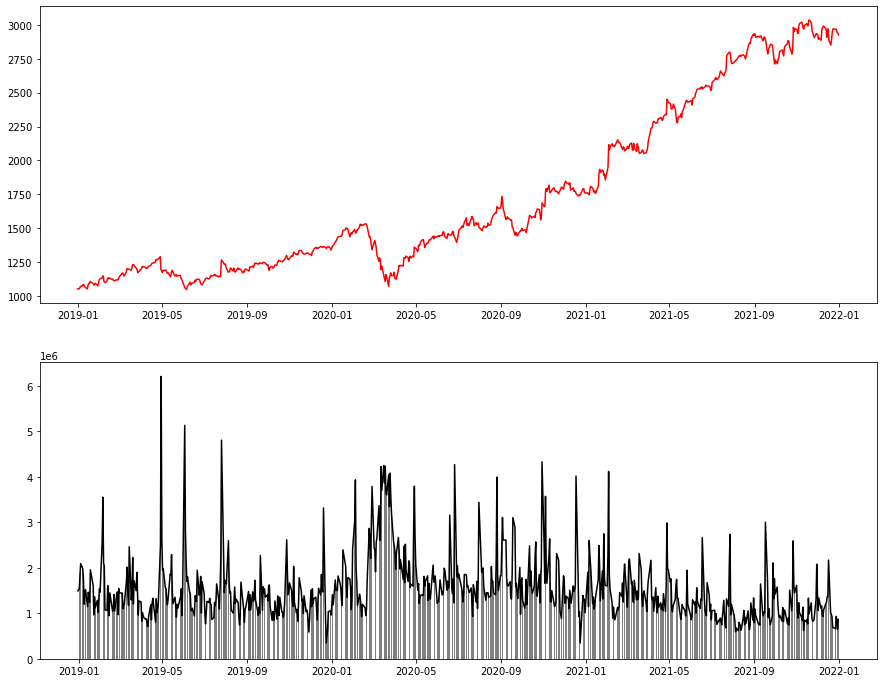

In [6]:
# lets compare between prices and volume
plt.figure(figsize = (15,12))

plt.subplot(2,1,1)
plt.plot(df['High'], color = 'red')

plt.subplot(2,1,2)
plt.bar(df.index.values, df['Volume'], color = 'grey')
plt.plot(df['Volume'], color = 'black' )
plt.show()

We can see that large spikes in volume corresponds to volatile trading periods, where the High price of the stock increases or decreases rapidly. This makes sense as volume gives us a sense of market activity, the price of a stock would increase rapidly if there is a sudden surge in buyers and the price of a stock will decrease with a surge of sellers.

We can gather that Volume, Open and Close are variables that can help us develop a forecast for future High prices for a stock. But for now, I have decided that I will try making a univariate LSTM with just High prices. Maybe I'll try multivariate LSTMs another day.

Our goal: To forecast the stock prices using data from the previous 2 months.

# 2. Data Processing

First of all let's split our data into a training set, to train the LSTM model and a testing set, for us to check the performance of our model.

A initial mistake I made here was using the train_test_split function from sklearn's model preprocessing. For LSTMs we would like the data to be in a sequence, corresponding to the dates. So indexing the dataframe would suffice.

In [7]:
df = df['High']

# Split data
train_data = df[:-60]
test_data = df[-60:]

Now we can normalise the data. This keeps our values in a general distribution, allowing greater accuracy and performance in the train stage. We can also write a function for that, we should return scaler too, so that we can use it to create a inverse transform function later.

It is also important to note that normalising data should come after splitting our data. Normalising the dataset before the split causes the mean and standard deviation of the training set to follow that of the whole dataset. This may leak information about the test set to the model.

In [8]:
# Create a function to normalise the data

from sklearn.preprocessing import MinMaxScaler

def scaledata(df):
    scaler = MinMaxScaler(feature_range = (0,1))
    df = scaler.fit_transform(np.array(df).reshape(-1,1))
    return df, scaler

# Normalise the training set
train_data, scaler = scaledata(train_data)

We can then start creating the input sequence into the LSTM. Let's write a quick function for that.

The idea is that our inputs consist of day 1 to day n, and a prediction of the next day, n + 1 will be our output.
And the next input would be day 2 to day n + 1, with n + 2 as our output. This will carry on until we reached the end of our training dataset.

In [9]:
# Create the data set we are training from the train data.

# Create a function to split the data based on timesets.

def splitdata(df, timestep):
    x = []
    y = []
    stop = len(df) - timestep 

    for i in range(0, stop):
        xvals = df[i : timestep + i]
        yvals = df[timestep + i]
        
        x.append(xvals)
        y.append(yvals)

    np_x = np.array(x).reshape(-1, timestep)
    np_y = np.array(y)
    
    return np_x, np_y

x_train, y_train = splitdata(train_data, 60)

And taking a look at our first and second created inputs, we can see that the function works as intended.

In [10]:
y_train[1]

array([0.0696165])

In [11]:
x_train[2]

array([0.00502403, 0.01236155, 0.01403448, 0.01962501, 0.01860323,
       0.01252569, 0.00862135, 0.00213881, 0.01723739, 0.02376226,
       0.02345788, 0.03222056, 0.02330433, 0.01982088, 0.01693295,
       0.02462254, 0.01879911, 0.01464331, 0.02303433, 0.03697349,
       0.04103404, 0.04516341, 0.05260148, 0.0526809 , 0.03036125,
       0.02722193, 0.03094623, 0.04119023, 0.04618512, 0.042744  ,
       0.04456518, 0.0393876 , 0.0401923 , 0.03412   , 0.03374945,
       0.03761411, 0.03812762, 0.03731762, 0.04243697, 0.05054739,
       0.05865259, 0.0646507 , 0.06356863, 0.05784523, 0.05272323,
       0.06813415, 0.08073927, 0.08123164, 0.07961694, 0.07892339,
       0.07544524, 0.08073927, 0.09510727, 0.09756901, 0.09662136,
       0.08412636, 0.08223745, 0.07415294, 0.06568566, 0.0696165 ])

# 3. Building the model

To create our model, we will use keras, an API for the Tensorflow library which allows us to develop our own deep learning models from Python.

We will try creating a stacked LSTM model, which consists of multiple layers of LSTM layers. This allows us to create a more complex feature representation of each input to discover more patterns.

We will start by adding layers of LSTM, making sure that return_sequence is true, allowing the sequence to output to the next layer.
We will also add a cheeky dropout layer, which randomly shuts off units in the network to prevent overfitting.
Finally, we will use a Dense layer, with a default activation to classify and deliver the final output.

Next we will compile our model. Mean squared error (MSE) is used as the loss function instead of cross entropy because we are trying to do a regression (forecasting future values of stock) instead of a classification problem.

Finally we will train the model using the training set we prepared.

In [29]:
import tensorflow as tf
from tensorflow import keras

# Building our model

model = keras.Sequential([
    keras.layers.LSTM(100,return_sequences = True, input_shape = (60,1)),
    keras.layers.LSTM(100, return_sequences = True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(100, return_sequences = True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(50),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
    
])

model.compile(optimizer = 'adam',
             loss = 'mean_squared_error')

# Training our model
model.fit(x_train, y_train, epochs = 50,validation_split = 0.1)

Epoch 1/50
18/18 [==============================] - 16s 250ms/step - loss: 0.0256 - val_loss: 0.0125
Epoch 2/50
18/18 [==============================] - 2s 121ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 3/50
18/18 [==============================] - 2s 138ms/step - loss: 0.0031 - val_loss: 0.0069
Epoch 4/50
18/18 [==============================] - 3s 155ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 5/50
18/18 [==============================] - 2s 128ms/step - loss: 0.0030 - val_loss: 0.0066
Epoch 6/50
18/18 [==============================] - 2s 125ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 7/50
18/18 [==============================] - 3s 170ms/step - loss: 0.0034 - val_loss: 0.0120
Epoch 8/50
18/18 [==============================] - 2s 135ms/step - loss: 0.0030 - val_loss: 0.0058
Epoch 9/50
18/18 [==============================] - 3s 171ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 10/50
18/18 [==============================] - 3s 161ms/step - loss: 0.0026 - val_loss: 0.004

# 4. Testing the model

Now we can start to create predictions using our model. First of all, we will gather the past 60 days from our main dataset to use as our input. We will then preprocess the data in a similar fashion to what we did for our training set.

In [30]:
df_to_array = np.array(df).reshape(-1)

In [31]:
# Create the test set
test_set = df_to_array[len(df_to_array) - len(test_data) - 60:]
test_set.shape

(120,)

In [32]:
test_data.shape

(60,)

In [33]:
# Normalise the test set
test_set, scaler = scaledata(test_set)

In [34]:
# Create test set
x_test = []
for i in range(0, 60):
    x_test.append(test_set[i : i + 60])
    
x_test = np.array(x_test)

In [35]:
# Reshape the array so that it matches the model inputs
x_test = x_test.reshape(60, 60)
x_test

array([[0.08489049, 0.06542726, 0.0454302 , ..., 0.21613368, 0.29680151,
        0.32058457],
       [0.06542726, 0.0454302 , 0.        , ..., 0.29680151, 0.32058457,
        0.43233787],
       [0.0454302 , 0.        , 0.03661398, ..., 0.32058457, 0.43233787,
        0.44022744],
       ...,
       [0.21613368, 0.29680151, 0.32058457, ..., 0.84092587, 0.83383497,
        0.83131097],
       [0.29680151, 0.32058457, 0.43233787, ..., 0.83383497, 0.83131097,
        0.77351614],
       [0.32058457, 0.43233787, 0.44022744, ..., 0.83131097, 0.77351614,
        0.76763096]])

In [36]:
# Create predictions
y_predict = model.predict(x_test)

In [37]:
y_predict.shape

(60, 1)

Now we can write a function to revert our normalised data back to their actual values. Afterwards, we can remove the index from test data and plot our predicted versus actual stock prices.

In [38]:
# Revert data back to original values

def revertdata(df):
    df = scaler.inverse_transform(np.array(df).reshape(-1,1))
    return df


y_predict = revertdata(y_predict)

In [39]:
# Drop the index within the pandas series
y_actual = test_data.reset_index(drop = True)

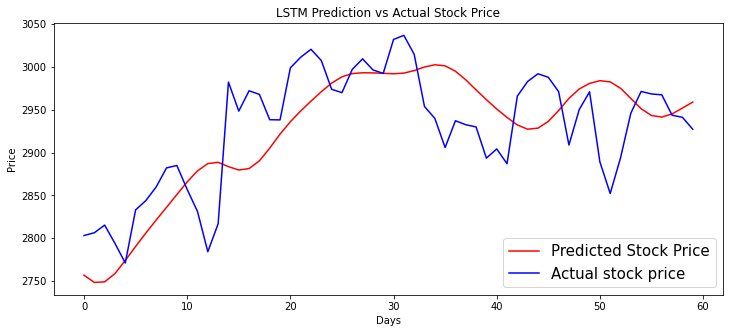

In [40]:
# Plot the differences between the predicted and actual value over each timestep

plt.figure(figsize = (12,5))
plt.plot(y_predict, color = 'red', label = 'Predicted Stock Price')
plt.plot(y_actual, color = 'blue', label = 'Actual stock price')
plt.title('LSTM Prediction vs Actual Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(loc = 'lower right', fontsize = 15)
plt.show()

It seems that our model is not working very well. While the general trend is there, the predictions do seem to deviate from the actual value.

# Conclusion

After some further research, I have developed some reasons as to why our model is not performing very well. Firstly, I could just be doing something wrong with the code maybe somewhere in the data processing section, but I can't tell for now.

Another reason could be that the model is predicting the next value of the stock based on the assumption that it will be not too different from the current price. However, due to the volatile, uncertain nature of stock movements, the model cannot keep up.


The last reason is one that would be going against the whole idea of LSTM acting as a predictor, which I found off this medium post by Analytics Vidhya: https://medium.com/analytics-vidhya/no-lstms-cant-predict-stock-prices-11f10dcb35d6#:~:text=Stock%20movements%20are%20essentially%20random,can%20not%20be%20consistently%20predicted.

But in general, this is because of the 'random walk theory'. The theory suggests that stock prices move in a random and unpredictable manner. This makes any attempt at creating a 'predictor' for stock prices invalid. 

We can try to challenge this last theory. Let's first gather the percentage change of the high price between each day and take a look at the distribution.

In [7]:
# Let's first find the percentage change each day
High = df_goog['High']

Change = []

for i in range(0, len(High) - 1):
    x1 = High[i]
    x2 = High[i + 1]
    diff = x2 - x1
    percentagediff = diff/x1
    
    Change.append(percentagediff)

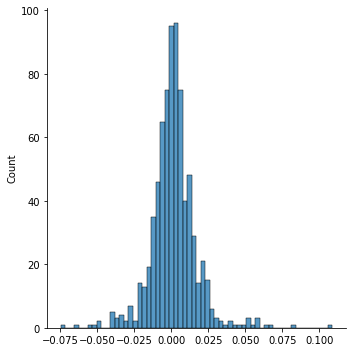

In [8]:
# Let's now plot the distribution
import seaborn as sns
sns.displot(Change)

It looks like the changes follows a normal distribution closely with a mean of 0. This implies that the high stock prices change daily in a random manner. Hence we can conclude that trying to predict future GOOG High prices using past prices would not really work.

We can now bring in the 'efficient market hypothesis' that hypothesizes that stock prices also accounts for all information available about the company. This information could range from company performance to social media sentiments. Trying to develop a stock forecasting bot with these variables in mind could be a good approach to take in the future, especially since we now know that relying solely on past stock prices might not be the best move. We can also try to develop a ensemble of models, where our LSTM model does not function as the sole predictor.

This has been a great project where I not just learnt more about LSTMs and neural networks, but I also learnt abit more about finance and the markets in general. I would probably come back to this problem again and try to forecast stock prices with a different approach, but for now, I'll just close this project and call it day.

Thank you all for reading and do let me know if I've made any mistakes throughout this post and of any possible improvements that I could implement, I am always happy to learn more.

Cheers, and have a nice day!